In [25]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#read in data
df = pd.read_csv('data.csv')
df

,respondentId,wave,age,sex,income,educ,feelings,city_size,ho,contacts
0,95,2,66,male,above median,university,8.0,>100k,not working,5
1,95,3,65,male,above median,university,3.0,>100k,not working,10
2,95,4,66,male,above median,university,5.0,>100k,not working,6
3,95,5,66,male,above median,university,6.0,>100k,in work,7
4,95,6,66,male,above median,university,4.0,>100k,not working,11
...,...,...,...,...,...,...,...,...,...,...
68727,274318,8,40,male,above median,high school,2.0,20k - 100k,in work,5
68728,274318,9,40,male,above median,high school,0.0,20k - 100k,"half work, half home",24
68729,274318,10,40,male,above median,high school,0.0,20k - 100k,not working,6
68730,274318,11,40,male,above median,high school,1.0,20k - 100k,in work,3


In [3]:
#filter contacts
df = df.loc[df['contacts'] < 100]
df.dropna(inplace = True)

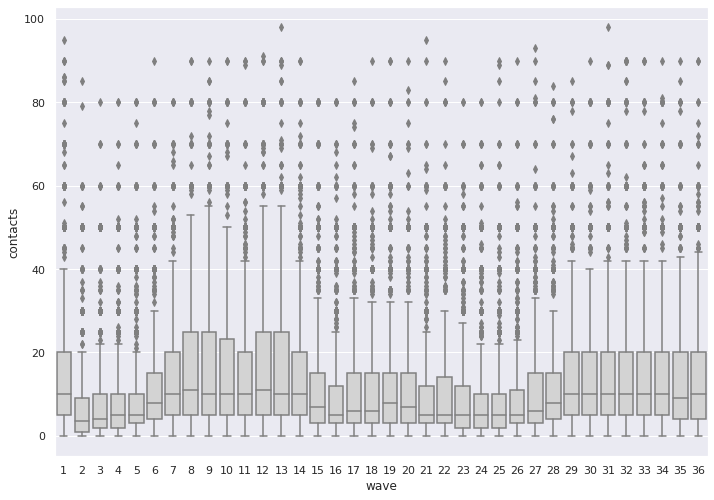

In [59]:
#figure 1
ax = sns.boxplot(x="wave", y="contacts", color = 'lightgray', data=df)

In [61]:
#figure 2 prep
grouped_prep = df.groupby(["ho", "city_size"])["sex"].count().reset_index()
tot = grouped_prep.groupby("city_size")["sex"].sum().reset_index().rename(columns = {"sex" : "total"})
ready_for_bar = grouped_prep.merge(tot, how = "left", on = "city_size")
ready_for_bar["prop"] = ready_for_bar["sex"] / ready_for_bar["total"]

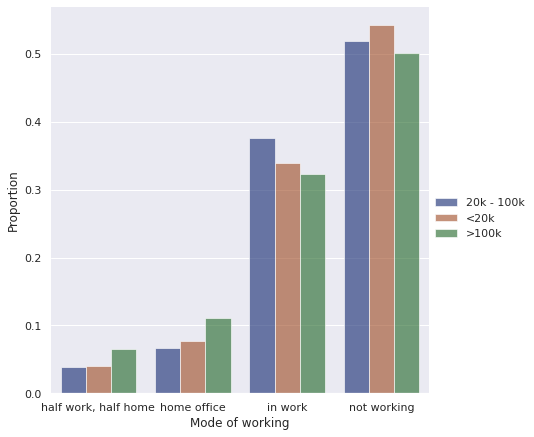

In [62]:
#figure 2
g = sns.catplot(
    data=ready_for_bar, kind="bar",
    x="ho", y="prop", hue="city_size",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Mode of working", "Proportion")
g.legend.set_title("")

In [4]:
#get dummies
predictors = pd.get_dummies(df)
predictors.drop(columns = ["respondentId", "wave", "contacts"], inplace = True)

In [6]:
#
predictors_1 = predictors.drop(columns = ['sex_male', 'income_below 60% median',
                                          'educ_basic', 'city_size_<20k', 'ho_in work', 'ho_half work, half home',
                                         'ho_home office', 'ho_not working'])

In [7]:
#
predictors_2 = predictors.drop(columns = ['sex_male', 'income_below 60% median',
                                          'educ_basic', 'city_size_<20k', 'ho_in work'])

In [8]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [9]:
predictors_1 = drop_column_using_vif_(predictors_1, thresh=5)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation


In [10]:
predictors_2 = drop_column_using_vif_(predictors_2, thresh=5)

Dropping: educ_high school with graduation


In [11]:
#model 1
model_1 = sm.OLS(endog=df[['contacts']], exog=sm.add_constant(predictors_1)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               contacts   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     482.9
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:33:40   Log-Likelihood:            -2.7739e+05
No. Observations:               68728   AIC:                         5.548e+05
Df Residuals:                   68717   BIC:                         5.549e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.7516      0.266     81.915      0.000      21.231      22.272
age                     -0.1758      0.003    -52.367      0.000      -0.182      -0.169
feelings                -0.3220      0.020    -16.258      0.000      -0.361      -0.283
sex_female              -0.9845      0.109     -9.024      0.000      -1.198      -0.771
income_above median      4.6396      0.188     24.724      0.000       4.272       5.007
income_below median      1.8985      0.187     10.176      0.000       1.533       2.264
income_undisclosed       2.0610      0.273      7.550      0.000       1.526       2.596
educ_high school        -0.1402      0.133     -1.054      0.292      -0.401       0.121
educ_university         -0.1723      0.127     -1.362      0.173      -0.420       0.076
city_size_20k - 100k    -0.2491      0.147     -1.690      0.091      -0.538       0.040
city_size_>100k         -0.7641      0.131     -5.820      0.000      -1.021      -0.507
==============================================================================
Omnibus:                    25673.542   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93335.832
Skew:                           1.895   Prob(JB):                         0.00
Kurtosis:                       7.269   Cond. No.                         398.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
#model 2
model_2 = sm.OLS(endog=df[['contacts']], exog=sm.add_constant(predictors_2)).fit()
model_2.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               contacts   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1213.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:33:40   Log-Likelihood:            -2.7262e+05
No. Observations:               68728   AIC:                         5.453e+05
Df Residuals:                   68714   BIC:                         5.454e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      24.2226      0.254     95.410      0.000      23.725      24.720
age                        -0.0715      0.004    -19.927      0.000      -0.079      -0.065
feelings                   -0.3038      0.018    -16.434      0.000      -0.340      -0.268
sex_female                  0.3561      0.103      3.461      0.001       0.154       0.558
income_above median         2.3943      0.178     13.486      0.000       2.046       2.742
income_below median         1.1437      0.174      6.560      0.000       0.802       1.485
income_undisclosed          0.9760      0.256      3.819      0.000       0.475       1.477
educ_high school           -0.6358      0.125     -5.103      0.000      -0.880      -0.392
educ_university             0.7161      0.119      6.031      0.000       0.483       0.949
city_size_20k - 100k       -0.8709      0.138     -6.324      0.000      -1.141      -0.601
city_size_>100k            -1.0465      0.123     -8.515      0.000      -1.287      -0.806
ho_half work, half home    -5.4420      0.232    -23.498      0.000      -5.896      -4.988
ho_home office            -12.4176      0.186    -66.810      0.000     -12.782     -12.053
ho_not working            -11.1800      0.123    -90.908      0.000     -11.421     -10.939
==============================================================================
Omnibus:                    25870.465   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104405.641
Skew:                           1.861   Prob(JB):                         0.00
Kurtosis:                       7.755   Cond. No.                         401.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
model_2.params["city_size_>100k"]

-1.0464897457834297

In [14]:
# model3

In [15]:
def prep_data_for_wave(df, wave):
    """
    """
    df_filtered = df.query("wave == @wave")
    endog = df_filtered[['contacts']]
    
    #get dummies
    predictors = pd.get_dummies(df_filtered)
    predictors.drop(columns = ["respondentId", "wave", "contacts"], inplace = True)
    #
    predictors_2 = predictors.drop(columns = ['sex_male', 'income_below 60% median',
                                          'educ_basic', 'city_size_<20k', 'ho_in work'])
    predictors_2 = drop_column_using_vif_(predictors_2, thresh=5)
    
    return(endog, predictors_2)

In [16]:
waves = list(range(1,37))

In [36]:
coefs = []
ci_lower = []
ci_upper = []
errors = []
for wave in waves:
    endog_var, predictors = prep_data_for_wave(df, wave)
    #model 2
    model_w = sm.OLS(endog=endog_var, exog=sm.add_constant(predictors)).fit()
    coef = model_w.params["city_size_>100k"]
    cis = model_w.conf_int().loc["city_size_>100k",:]
    se = model_w.bse["city_size_>100k"]*1.96
    ci_lower.append(cis[0])
    ci_upper.append(cis[1])
    if model_w.pvalues["city_size_>100k"]<0.05:
        print(wave, model_w.pvalues["city_size_>100k"])
    coefs.append(coef)
    errors.append(se)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
3 0.009212765643137026
4 0.017344452580487217
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


6 0.011100740723270415
Dropping: educ_high school with graduation
7 0.01894215874140836
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
13 0.03674542104722567


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
20 0.03770882776964783
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
22 0.019055087079377194
Dropping: educ_high school with graduation
23 0.04616766522400313
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: educ_high school with graduation
29 0.019498946906146033
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
31 0.010901005527145189
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/

Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation
Dropping: educ_high school with graduation


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [37]:
regression_df = pd.DataFrame({"wave": waves, "coefs": coefs, "ci_lower": ci_lower, "ci_upper": ci_upper, "errors": errors})

In [38]:
regression_df

,wave,coefs,ci_lower,ci_upper,errors
0,1,-0.831789,-2.380942,0.717364,1.548322
1,2,-0.744699,-1.573330,0.083931,0.828201
2,3,-1.132139,-1.983987,-0.280291,0.851427
3,4,-1.125564,-2.052567,-0.198560,0.926547
4,5,-0.897650,-1.981575,0.186275,1.083363
5,6,-1.535039,-2.719419,-0.350659,1.183763
6,7,-1.625047,-2.982044,-0.268050,1.356264
7,8,-0.484217,-2.081954,1.113521,1.596804
8,9,-0.929813,-2.604812,0.745186,1.673988
9,10,-0.690696,-2.324341,0.942949,1.632637


In [41]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Wave'), Text(0, 0.5, 'Coefficient')]

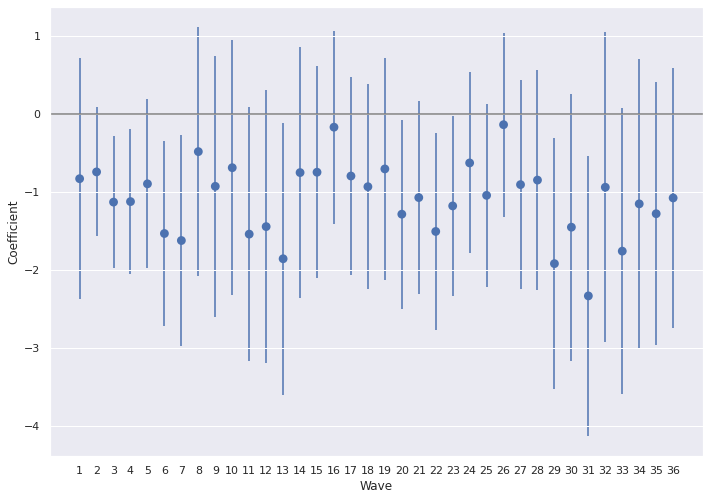

In [44]:
ax = sns.pointplot('wave', 'coefs',
    data=regression_df, dodge=True, join=False, ci=None)
# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', zorder=-1)
plt.axhline(y=0, color='gray', linestyle='-')
ax.set(xlabel='Wave', ylabel='Coefficient')

In [45]:
# model with interaction terms

In [54]:
import statsmodels.formula.api as smf
from patsy.contrasts import Treatment

In [63]:
results = smf.ols("contacts ~ age + sex + educ + income + C(ho, Treatment('in work')) + C(city_size , Treatment('<20k')) + C(ho, Treatment('in work'))*C(city_size , Treatment('<20k'))", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               contacts   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     820.1
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:42:19   Log-Likelihood:            -2.7270e+05
No. Observations:               68728   AIC:                         5.454e+05
Df Residuals:                   68708   BIC:                         5.456e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            26.4150      0.312     84.704      0.000      25.804      27.026
sex[T.male]                                                                                          -0.1287      0.102     -1.259      0.208      -0.329       0.072
educ[T.high school]                                                                                  -0.4474      0.249     -1.795      0.073      -0.936       0.041
educ[T.high school with graduation]                                                                   0.1899      0.246      0.772      0.440      -0.292       0.672
educ[T.university]                                                                                    0.9015      0.252      3.583      0.000       0.408       1.395
income[T.below 60% median]                                                                           -2.5488      0.178    -14.283      0.000      -2.899      -2.199
income[T.below median]                                                                               -1.3383      0.115    -11.648      0.000      -1.563      -1.113
income[T.undisclosed]                                                                                -1.4339      0.215     -6.680      0.000      -1.855      -1.013
C(ho, Treatment('in work'))[T.half work, half home]                                                  -8.0121      0.491    -16.334      0.000      -8.973      -7.051
C(ho, Treatment('in work'))[T.home office]                                                          -14.5313      0.374    -38.804      0.000     -15.265     -13.797
C(ho, Treatment('in work'))[T.not working]                                                          -12.4538      0.212    -58.870      0.000     -12.868     -12.039
C(city_size, Treatment('<20k'))[T.20k - 100k]                                                        -2.5328      0.228    -11.106      0.000      -2.980      -2.086
C(city_size, Treatment('<20k'))[T.>100k]                                                             -2.1374      0.205    -10.449      0.000      -2.538      -1.736
C(ho, Treatment('in work'))[T.half work, half home]:C(city_size, Treatment('<20k'))[T.20k - 100k]     5.5198      0.721      7.652      0.000       4.106       6.934
C(ho, Treatment('in work'))[T.home office]:C(city_size, Treatment('<20k'))[T.20k - 100k]              3.6343      0.558      6.515      0.000       2.541       4.728
C(ho, Treatment('in work'))[T.not working]:C(city_size, Treatment('<20k'))[T.20k - 100k]       